In [ ]:
import pandas as pd
import numpy as np

# Generate synthetic data
np.random.seed(42)
date_range = pd.date_range(start='1/1/2020', periods=1000, freq='H')
cpu_usage = np.random.normal(loc=50, scale=10, size=len(date_range))
memory_usage = np.random.normal(loc=60, scale=15, size=len(date_range))
network_latency = np.random.normal(loc=20, scale=5, size=len(date_range))
incidents = np.random.choice([0, 1], size=len(date_range), p=[0.95, 0.05])

data = {
    'timestamp': date_range,
    'cpu_usage': cpu_usage,
    'memory_usage': memory_usage,
    'network_latency': network_latency,
    'incident': incidents
}

df = pd.DataFrame(data)
df.to_csv('it_operations_data.csv', index=False)

In [ ]:
df['cpu_usage_rolling_mean'] = df['cpu_usage'].rolling(window=24).mean()
df['memory_usage_rolling_mean'] = df['memory_usage'].rolling(window=24).mean()
df['network_latency_rolling_mean'] = df['network_latency'].rolling(window=24).mean()
df['cpu_usage_spike'] = df['cpu_usage'] - df['cpu_usage_rolling_mean']
df['memory_usage_spike'] = df['memory_usage'] - df['memory_usage_rolling_mean']
df['network_latency_spike'] = df['network_latency'] - df['network_latency_rolling_mean']


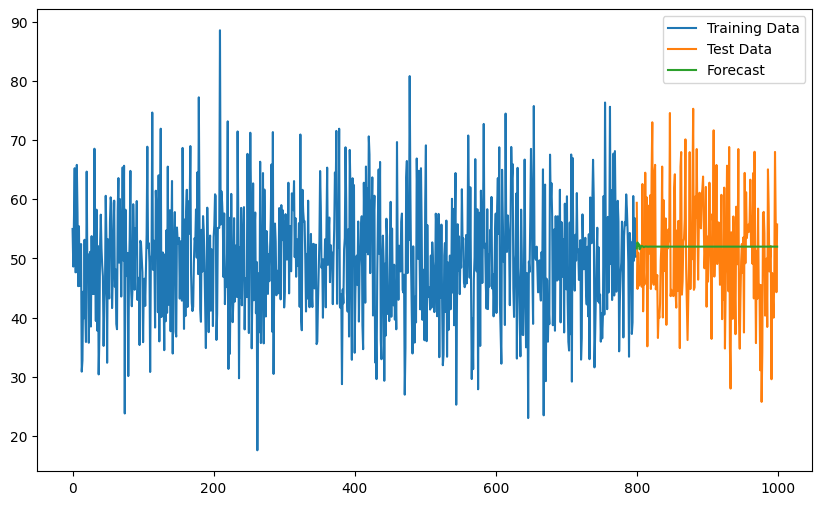

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# Train-test split
train = df['cpu_usage'][:800]
test = df['cpu_usage'][800:]

# Fit ARIMA model
model = ARIMA(train, order=(5, 1, 0))
model_fit = model.fit()

# Forecast
forecast = model_fit.forecast(steps=200)

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(train.index, train, label='Training Data')
plt.plot(test.index, test, label='Test Data')
plt.plot(test.index, forecast, label='Forecast')
plt.legend()
plt.show()



/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


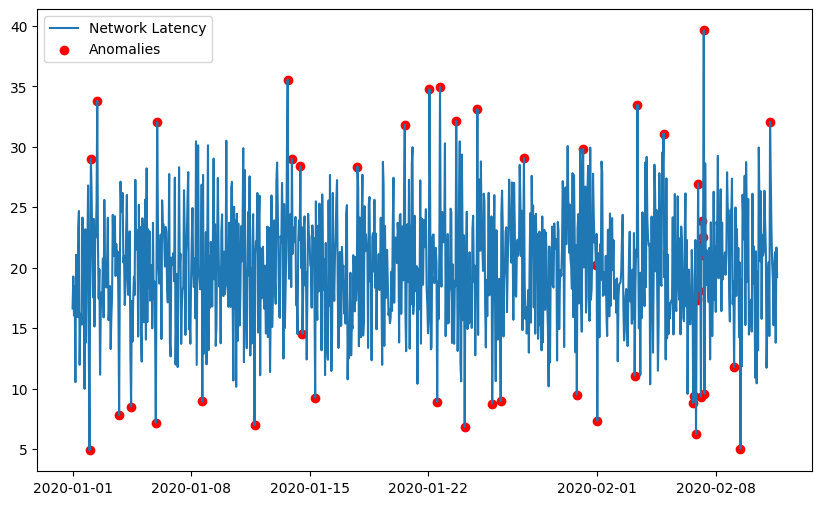

In [ ]:
from sklearn.ensemble import IsolationForest

# Prepare data for anomaly detection
features = ['network_latency', 'network_latency_rolling_mean', 'network_latency_spike']
X = df[features].dropna()

# Fit Isolation Forest
clf = IsolationForest(contamination=0.05, random_state=42)
clf.fit(X)

# Predict anomalies
anomalies = clf.predict(X)

# Assign anomalies to DataFrame
df['anomaly'] = pd.Series(anomalies, index=X.index)

# Plot anomalies
anomalies_df = df[df['anomaly'] == -1]
plt.figure(figsize=(10, 6))
plt.plot(df['timestamp'], df['network_latency'], label='Network Latency')
plt.scatter(anomalies_df['timestamp'], anomalies_df['network_latency'], color='red', label='Anomalies')
plt.legend()
plt.show()


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Prepare data for classification
features = ['cpu_usage', 'memory_usage', 'network_latency', 'cpu_usage_spike', 'memory_usage_spike', 'network_latency_spike']
X = df[features].dropna()
y = df['incident'].iloc[X.index]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit Random Forest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Predictions
y_pred = clf.predict(X_test)

# Handle UndefinedMetricWarning by setting zero_division=1
print(classification_report(y_test, y_pred, zero_division=1))


              precision    recall  f1-score   support

           0       0.93      1.00      0.96       182
           1       1.00      0.00      0.00        14

    accuracy                           0.93       196
   macro avg       0.96      0.50      0.48       196
weighted avg       0.93      0.93      0.89       196



In [ ]:
from sklearn.model_selection import cross_val_score

# Cross-validation for Random Forest classifier
scores = cross_val_score(clf, X, y, cv=5)
print("Random Forest Cross-Validation Scores: ", scores)
print("Mean Score: ", scores.mean())


Random Forest Cross-Validation Scores:  [0.95408163 0.95408163 0.95384615 0.94871795 0.95384615]
Mean Score:  0.9529147043432757


In [ ]:
from sklearn.model_selection import GridSearchCV

# Grid search for Random Forest hyperparameters
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)
print("Best Parameters: ", grid_search.best_params_)


Fitting 3 folds for each of 108 candidates, totalling 324 fits
